# Incident Management

## Exploratory Data Analysis Report - Pre-Closure

In [1]:
# Importação de Bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from win32com.client import Dispatch
import base64
import datetime


In [2]:
# Load the dataset from a CSV file.
df = pd.read_csv('../input_data/incident.csv')


In [3]:
# Print the list of columns in the dataframe
#print(f'Lista de Colunas:\n{df.columns.tolist()}')
print(f'Lista de Colunas:\n{df.columns}')


Lista de Colunas:
Index(['number', 'caller_id', 'u_incident_type', 'impact', 'short_description',
       'u_impacted_area', 'u_impacted_business_unit', 'assignment_group',
       'assignment_group.manager.email', 'assigned_to', 'assigned_to.email',
       'u_site', 'u_reporting_level', 'incident_state', 'u_service',
       'u_service.u_accountmanager.email', 'u_service.owned_by.email',
       'u_resolution_sla.percentage', 'u_accepted_at', 'opened_at',
       'sys_updated_on', 'u_target_resolution_time', 'u_supplier', 'cmdb_ci',
       'cmdb_ci.category', 'cmdb_ci.u_folder', 'cmdb_ci.manufacturer',
       'cmdb_ci.model_id', 'cmdb_ci.model_number', 'cmdb_ci.serial_number',
       'cmdb_ci.asset_tag', 'u_complaint_reason', 'reassignment_count',
       'u_reassign_reason', 'reopen_count', 'u_date_worked',
       'u_effort_service', 'u_time_worked_total'],
      dtype='object')


In [4]:
# Clean up the dataset by converting columns to appropriate data types.

#df.ffill(inplace=True)

In [5]:
def pre_process_dataset(df_processing):
    """
    Pre-process the dataset by converting columns to appropriate data types.
    """
    date_format = '%Y-%m-%d %H:%M:%S'

    # Iterate through all columns of the DataFrame
    for column in df_processing.columns:
        # Check if the column is of object type (string)
        if df_processing[column].dtype == 'object':
            # Check if the column can be converted to numeric
            if pd.to_numeric(df_processing[column], errors='coerce').notnull().all():
                df_processing[column] = pd.to_numeric(df_processing[column])
            # Check if the column can be converted to datetime
            elif pd.to_datetime(df_processing[column], format=date_format, errors='coerce').notnull().all():
                df_processing[column] = pd.to_datetime(
                    df_processing[column], format=date_format, errors='coerce')
        # Check if the column is of float type
        elif df_processing[column].dtype == 'float64':
            continue  # Mantém a coluna como float64
        # Check if the column is of int type
        elif df_processing[column].dtype == 'int64':
            df_processing[column] = df_processing[column].astype('int64')
        # Check if the column is of bool type
        elif df_processing[column].dtype == 'bool':
            df_processing[column] = df_processing[column].astype('bool')
        # Check if the column is of datetime type
        elif pd.api.types.is_datetime64_any_dtype(df_processing[column]):
            df_processing[column] = pd.to_datetime(
                df_processing[column], format=date_format, errors='coerce')
        # Convert other types to object
        else:
            df_processing[column] = df_processing[column].astype('object')
    return df_processing

df = pre_process_dataset(df)

In [6]:
# Print the list of columns in the dataframe
#print(f'Lista de Colunas com tipos:\n{df.dtypes.tolist()}')
print(f'Lista de Colunas com tipos:\n{df.dtypes}')


Lista de Colunas com tipos:
number                                      object
caller_id                                   object
u_incident_type                             object
impact                                      object
short_description                           object
u_impacted_area                             object
u_impacted_business_unit                    object
assignment_group                            object
assignment_group.manager.email              object
assigned_to                                 object
assigned_to.email                           object
u_site                                      object
u_reporting_level                           object
incident_state                              object
u_service                                   object
u_service.u_accountmanager.email            object
u_service.owned_by.email                    object
u_resolution_sla.percentage                float64
u_accepted_at                               object
ope

In [7]:
df.rename(columns={
    'number'                        : 'Number', 
    'opened_at'                     : 'Opened',
    'u_target_resolution_time'      : 'TRT',
    'short_description'             : 'Short_Description',
    'assigned_to'                   : 'Assigned',
    'u_reporting_level'             : 'Level',
    'incident_state'                : 'Incident_State',
    'caller_id'                     : 'Caller', 
    'u_site'                        : 'Site',
    'assignment_group'              : 'Assignment_Group', 
    'u_resolution_sla.percentage'   : 'SLA',
    'u_accepted_at'                 : 'Accepted',
    'u_service'                     : 'Service',       
    'sys_updated_on'                : 'Updated',
    'u_incident_type'               : 'Incident_Type',
    'impact'                        : 'Impact',
    'u_supplier'                    : 'Supplier', 
    'assigned_to.email'             : 'Assigned_Email',
    'u_impacted_area'               : 'Area',
    'u_impacted_business_unit'      : 'BU',
    'cmdb_ci'                       : 'CI_CMDB'
}, inplace=True)


In [8]:
def customising_order_of_columns(df, format_view):
    if format_view == "std_view":
        columns_list = df[['Number','Caller','Area','BU','Opened','TRT','Service','Assignment_Group','Assigned','Updated','Incident_Type','Impact']].copy()

    if format_view == "incident_view":
        columns_list = df[['Number','Service','Area','BU','Opened','TRT','Caller','Assignment_Group','Assigned','Updated','Incident_Type','Impact']].copy()

    if format_view == "ci_view":
        columns_list = df[['Number','Service','Area','BU','Opened','Caller','Assignment_Group','Assigned','Incident_Type','Impact','CI_CMDB']].copy()

    if format_view == "supplier_view":
        columns_list = df[['Number','Service','Area','BU','Opened','Caller','Assignment_Group','Assigned','Incident_Type','Impact','Supplier']].copy()

    return columns_list

In [9]:
def convert_category_data_to_discrete_data(df_processing):
    """
    Converts categorical data to discrete data by applying factorization.
    Returns:
    None
    """
    df_data_proc = df_processing.copy()
    df_data_proc['incident_state_disc'], uniques   = pd.factorize(df_data_proc['Incident_State'])
    df_data_proc['caller_disc'], uniques           = pd.factorize(df_data_proc['Caller'])
    df_data_proc['site_disc'], uniques             = pd.factorize(df_data_proc['Site'])
    df_data_proc['assignment_group_disc'], uniques = pd.factorize(df_data_proc['Assignment_Group'])
    df_data_proc['incident_type_disc'], uniques    = pd.factorize(df_data_proc['Incident_Type'])
    df_data_proc['impact_disc'], uniques           = pd.factorize(df_data_proc['Impact'])
    df_data_proc['bu_disc'], uniques               = pd.factorize(df_data_proc['BU'])
    df_data_proc['supplier_disc'], uniques         = pd.factorize(df_data_proc['Supplier'])    
    return df_data_proc

#df_describe = convert_category_data_to_discrete_data(df)


In [10]:
print(df.dtypes)

Number                                      object
Caller                                      object
Incident_Type                               object
Impact                                      object
Short_Description                           object
Area                                        object
BU                                          object
Assignment_Group                            object
assignment_group.manager.email              object
Assigned                                    object
Assigned_Email                              object
Site                                        object
Level                                       object
Incident_State                              object
Service                                     object
u_service.u_accountmanager.email            object
u_service.owned_by.email                    object
SLA                                        float64
Accepted                                    object
Opened                         

### 1.0 - Heatmap for correlation analysis between Incident Types and Impact

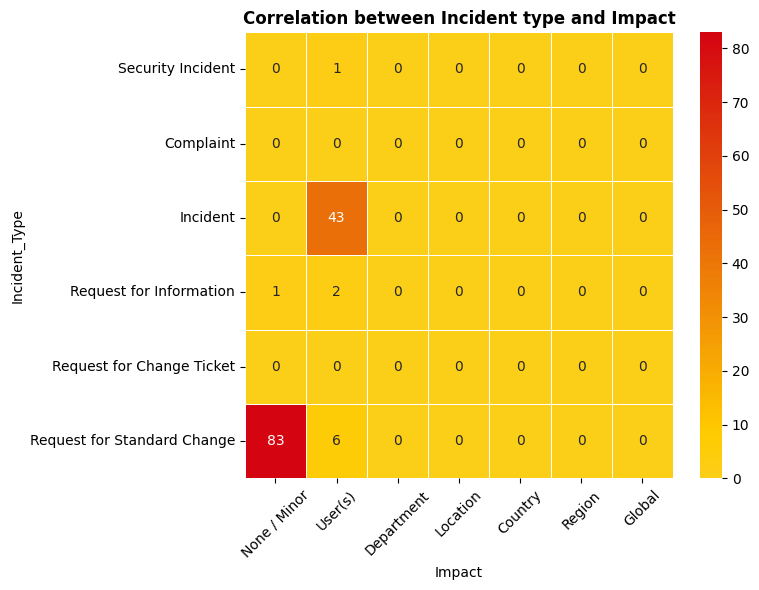

In [11]:
# 1.0 - Heatmap for correlation analysis between Incident Types and Impact

label_incident_type_order = ['Security Incident','Complaint','Incident', 'Request for Information','Request for Change Ticket','Request for Standard Change']
label_impact_order = ['None / Minor', 'User(s)','Department','Location','Country','Region','Global']

cmap = LinearSegmentedColormap.from_list("custom_cmap",["#DCDCDC", "#FFCC00", "#D40511"])

matrix_incident_type_w_impact = pd.crosstab(df['Incident_Type'], df['Impact']).reindex(index=label_incident_type_order, columns=label_impact_order, fill_value=0)

plt.figure(figsize=(8, 6))
sns.heatmap(matrix_incident_type_w_impact, annot=True, cmap=cmap, center=8, linewidths=0.5, fmt=".0f")    
plt.title('Correlation between Incident type and Impact').set_weight('bold')
plt.xlabel('Impact').set_animated(True)
plt.ylabel('Incident_Type')
plt.xticks(rotation=45)
plt.tight_layout()
    
#plt.savefig('./output_data/html_element_1_0.png', dpi=150)
plt.show()

In [12]:
#Report listing the incident type filtered as "Incident" and the impact filtered as "None / Minor".
    
df_1_1 = df[(df['Incident_Type'] == 'Incident') & (df['Impact'] == 'None / Minor')]
df_1_1 = customising_order_of_columns(df_1_1, 'incident_view')
df_1_1.head()   

,Number,Service,Area,BU,Opened,TRT,Caller,Assignment_Group,Assigned,Updated,Incident_Type,Impact


In [13]:
#Report listing the incident type filtered as "Request for ..." and the impact filtered as different of "None / Minor"

df_1_2 = df[(df['Incident_Type'].str.startswith("Request for", na=False)) & (df['Impact'] != "None / Minor")]
df_1_2 = customising_order_of_columns(df_1_2, 'incident_view') 
df_1_2.head()   


,Number,Service,Area,BU,Opened,TRT,Caller,Assignment_Group,Assigned,Updated,Incident_Type,Impact
1,INC61458573,DESKTOP SUPPORT DSC LATAM,BR,DSC,2024-10-28 17:07:24,2024-11-04 17:07:24,leonardo santana marcondes pereira,AMER-ITS-BR-FieldSupport,NaN,2024-10-28 17:15:52,Request for Standard Change,User(s)
2,INC61458545,CLOUD IDENTITY,BR,DSC,2024-10-28 17:05:02,2024-11-04 17:05:02,Paloma Ester Ferreira Lima,AMER-ITS-BR-FieldSupport,NaN,2024-10-28 17:15:29,Request for Standard Change,User(s)
3,INC61458464,UNKNOWN,BR,Express,2024-10-28 16:56:14,2024-11-04 16:56:14,Luciane Silva,AMER-ITS-BR-FieldSupport,NaN,2024-10-28 16:57:57,Request for Standard Change,User(s)
8,INC61457982,DESKTOP SUPPORT DSC LATAM,BR,DSC,2024-10-28 15:59:25,2024-11-04 15:59:25,Portariasouzalima Agco,AMER-ITS-BR-FieldSupport,NaN,2024-10-28 17:01:25,Request for Standard Change,User(s)
9,INC61457961,DESKTOP SUPPORT DSC LATAM,CL,DSC,2024-10-28 15:57:00,2024-11-04 14:00:00,Damian Antonio Acevedo Gonzalez,AMER-ITS-CL-EUS-Chile,NaN,2024-10-28 15:59:25,Request for Information,User(s)


### 2.0 - Heatmap for correlation analysis between Impacted Service and Impacted BU

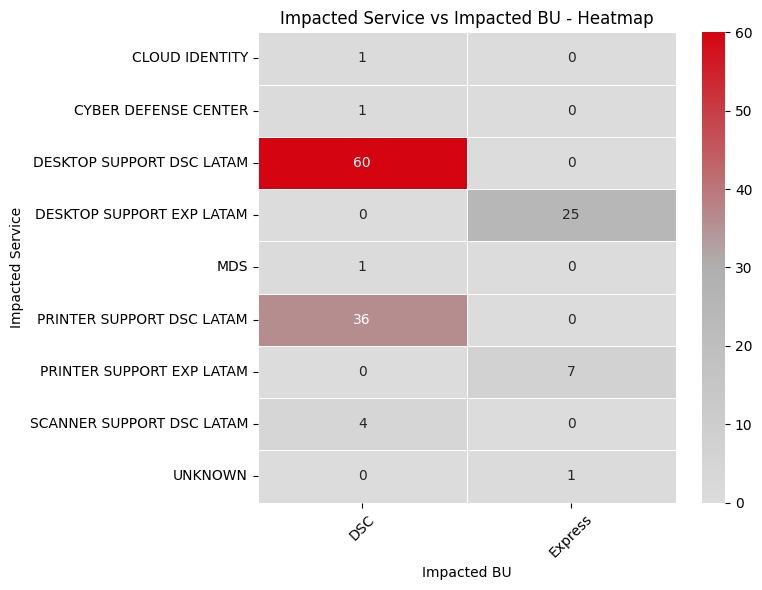

In [14]:
# 2.0 - Heatmap for correlation analysis between Impacted Service and Impacted BU.
cmap = LinearSegmentedColormap.from_list("custom_cmap",["#DCDCDC", "#AFAFAF", "#D40511"])
cross_tab = pd.crosstab(df['Service'], df['BU'])
plt.figure(figsize=(8, 6))
sns.heatmap(cross_tab, annot=True, cmap=cmap, linewidths=0.5, fmt=".0f")
plt.title('Impacted Service vs Impacted BU - Heatmap')
plt.xlabel('Impacted BU').set_animated(True)
plt.ylabel('Impacted Service')
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig('./output_data/html_element_2_0.png', dpi=150)
plt.show()

In [15]:
# 2.1 - Report that lists the incidents in which the Service does not contain the word "...LATAM".

df_2_1 = df[~df['Service'].str.contains(" LATAM", regex=False, na=False)]
df_2_1 = customising_order_of_columns(df_2_1, 'incident_view')
df_2_1.head()

,Number,Service,Area,BU,Opened,TRT,Caller,Assignment_Group,Assigned,Updated,Incident_Type,Impact
2,INC61458545,CLOUD IDENTITY,BR,DSC,2024-10-28 17:05:02,2024-11-04 17:05:02,Paloma Ester Ferreira Lima,AMER-ITS-BR-FieldSupport,NaN,2024-10-28 17:15:29,Request for Standard Change,User(s)
3,INC61458464,UNKNOWN,BR,Express,2024-10-28 16:56:14,2024-11-04 16:56:14,Luciane Silva,AMER-ITS-BR-FieldSupport,NaN,2024-10-28 16:57:57,Request for Standard Change,User(s)
24,INC61455388,MDS,BR,DSC,2024-10-28 12:14:10,2024-11-04 12:14:10,Jorge Paulo Cipullo,AMER-ITS-BR-FieldSupport,Juan Junior Andrade,2024-10-28 14:11:07,Request for Standard Change,None / Minor
30,INC61452515,CYBER DEFENSE CENTER,BR,DSC,2024-10-28 09:32:42,2024-11-04 09:32:42,Cyber Defense Center,AMER-ITS-BR-FieldSupport,Carlos Antonio Gomes Silva,2024-10-28 09:41:11,Security Incident,User(s)


In [16]:
# 2.2 - Report that lists the incidents in which the Service is "DESKTOP SUPPORT DSC LATAM" and the BU is different from "DSC".

df_2_2 = df[(df['Service'] == "DESKTOP SUPPORT DSC LATAM") & (df['BU'] != "DSC")]
df_2_2 = customising_order_of_columns(df_2_2, 'incident_view')
df_2_2.head()

,Number,Service,Area,BU,Opened,TRT,Caller,Assignment_Group,Assigned,Updated,Incident_Type,Impact


In [17]:
# 2.3 - Report that lists the incidents in which the Service is "DESKTOP SUPPORT EXP LATAM" and the BU is different from "Express".

df_2_3 = df[(df['Service'] == "DESKTOP SUPPORT EXP LATAM") & (df['BU'] != "Express")]
df_2_3 = customising_order_of_columns(df_2_3, 'incident_view')
df_2_3.head()

,Number,Service,Area,BU,Opened,TRT,Caller,Assignment_Group,Assigned,Updated,Incident_Type,Impact


### 3.0 - Heatmap for correlation analysis between Assigned Group and Impacted Service

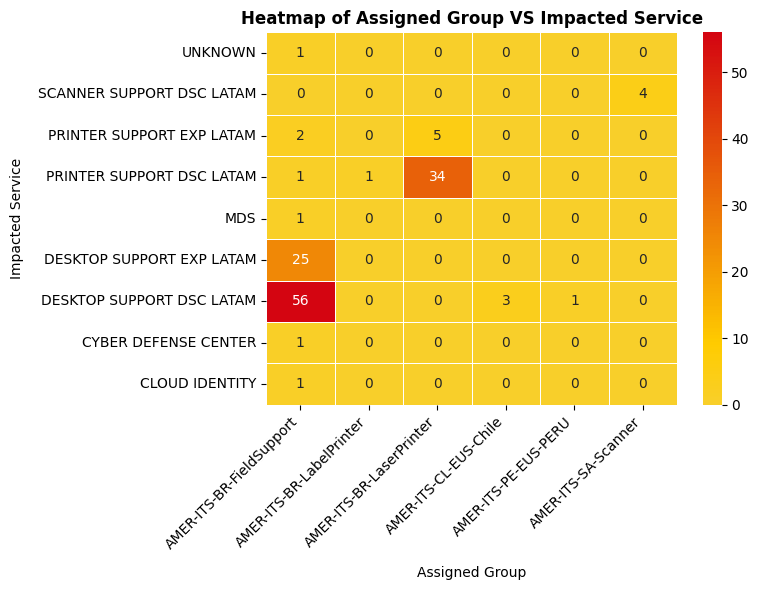

In [18]:
# 3.0 - Heatmap for correlation analysis between Assigned Group and Impacted Service

cmap = LinearSegmentedColormap.from_list("custom_cmap",["#DCDCDC", "#FFCC00", "#D40511"])

grouped_data = df.groupby(['Service', 'Assignment_Group']).size().unstack(fill_value=0)
grouped_data = grouped_data.sort_values(by='Service', ascending=False)

plt.figure(figsize=(8, 6))
sns.heatmap(grouped_data, annot=True, cmap=cmap, center=9, linewidths=0.5, fmt=".0f")

plt.title('Heatmap of Assigned Group VS Impacted Service').set_weight('bold')
plt.xlabel('Assigned Group', labelpad=10)
plt.ylabel('Impacted Service', labelpad=10).set_animated(True)
plt.xticks(rotation=45)
plt.tight_layout()

ax = plt.gca()
for tick in ax.get_xticklabels():
    tick.set_horizontalalignment('right')
    tick.set_x(tick.get_position()[0] - 1)

#plt.savefig('./output_data/html_element_3_0.png', dpi=150)
plt.show()

In [19]:
# Relatorio em grouped_incidents Totalizando o Agrupamento de Incidentes por Assignee > Assigned_Group > Area > BU > Service > Incident_Type incluindo os registros missing ou NaN

# Fill missing values with 'Unknown' before grouping
df_filled = df.fillna('Unknown')

# Grouping the incidents by Assignee, Assigned_Group, Area, BU, Service, and Incident_Type
grouped_incidents = df_filled.groupby(['Assigned', 'Assignment_Group', 'Area', 'BU', 'Service', 'Incident_Type']).size().reset_index(name='Count')

grouped_incidents = df_filled.groupby(['Assigned', 'Assignment_Group', 'Area', 'BU', 'Service', 'Incident_Type']).size().reset_index(name='Count')


# Display the grouped incidents
grouped_incidents.head()



,Assigned,Assignment_Group,Area,BU,Service,Incident_Type,Count
0,Alexsandro Oliveira,AMER-ITS-SA-Scanner,BR,DSC,SCANNER SUPPORT DSC LATAM,Incident,1
1,Alexsandro Oliveira,AMER-ITS-SA-Scanner,BR,DSC,SCANNER SUPPORT DSC LATAM,Request for Standard Change,1
2,Allan Roberto Costa Silva,AMER-ITS-BR-FieldSupport,BR,DSC,DESKTOP SUPPORT DSC LATAM,Request for Standard Change,5
3,Arthur da Fonseca Junior,AMER-ITS-BR-LaserPrinter,BR,DSC,PRINTER SUPPORT DSC LATAM,Incident,6
4,Arthur da Fonseca Junior,AMER-ITS-BR-LaserPrinter,BR,DSC,PRINTER SUPPORT DSC LATAM,Request for Standard Change,7


### 4.0 - The field "Configuration Item" as Null value or "NoRecord". 

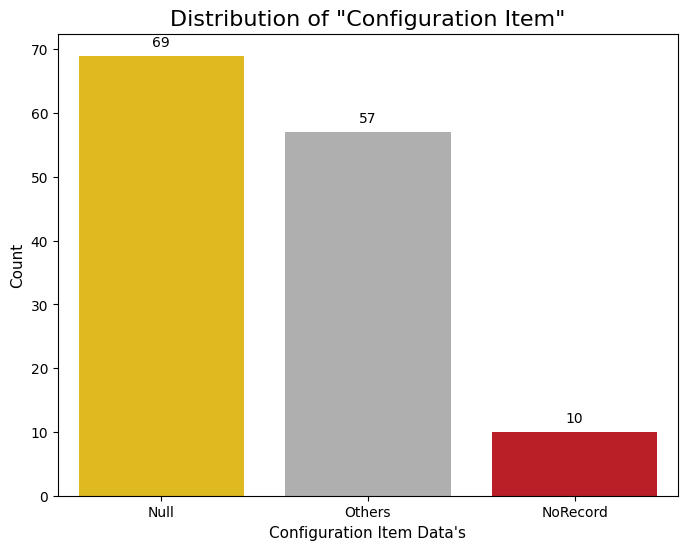

In [20]:
# 4.0 - The field "Configuration Item" as Null value or "NoRecord". 

df['CI_CMDB_Status'] = df['CI_CMDB'].apply(lambda x: 'NoRecord' if x == 'NORECORD' else ('Null' if pd.isnull(x) else 'Others'))
config_item_counts = df['CI_CMDB_Status'].value_counts()
custom_colors = ['#FFCC00', '#AFAFAF', '#D40511'] 
plt.figure(figsize=(8, 6))
sns.barplot(x=config_item_counts.index, y=config_item_counts.values, hue=config_item_counts.index, palette=custom_colors, legend=False)
plt.title('Distribution of "Configuration Item"', fontsize=16)
plt.xlabel("Configuration Item Data's", fontsize=11)
plt.ylabel('Count', fontsize=11)
for i, value in enumerate(config_item_counts.values):
    plt.text(i, value + 1, str(value), ha='center', va='bottom')


In [21]:
# 4.1 Report listing the incidents in which the Configuration Item is null.

df_4_1 = df[(df['CI_CMDB'].isnull())]
df_4_1 = customising_order_of_columns(df_4_1, 'ci_view')
df_4_1.head()


,Number,Service,Area,BU,Opened,Caller,Assignment_Group,Assigned,Incident_Type,Impact,CI_CMDB
0,INC61458671,DESKTOP SUPPORT DSC LATAM,BR,DSC,2024-10-28 17:15:32,Bruno Vinicius Machado,AMER-ITS-BR-FieldSupport,NaN,Incident,User(s),NaN
1,INC61458573,DESKTOP SUPPORT DSC LATAM,BR,DSC,2024-10-28 17:07:24,leonardo santana marcondes pereira,AMER-ITS-BR-FieldSupport,NaN,Request for Standard Change,User(s),NaN
3,INC61458464,UNKNOWN,BR,Express,2024-10-28 16:56:14,Luciane Silva,AMER-ITS-BR-FieldSupport,NaN,Request for Standard Change,User(s),NaN
6,INC61458059,DESKTOP SUPPORT DSC LATAM,BR,DSC,2024-10-28 16:06:28,Rafael Oliveira,AMER-ITS-BR-FieldSupport,NaN,Incident,User(s),NaN
7,INC61458003,DESKTOP SUPPORT DSC LATAM,BR,DSC,2024-10-28 16:00:42,Felipe Escautaborgo De Sousa,AMER-ITS-BR-FieldSupport,NaN,Incident,User(s),NaN


In [22]:
# 4.2 Report listing the incidents in which the Configuration Item is null.

df_4_2 = df[df['CI_CMDB'] == 'NORECORD']
df_4_2 = customising_order_of_columns(df_4_2, 'ci_view')
df_4_2.head()


,Number,Service,Area,BU,Opened,Caller,Assignment_Group,Assigned,Incident_Type,Impact,CI_CMDB
10,INC61457400,DESKTOP SUPPORT DSC LATAM,BR,DSC,2024-10-28 14:53:07,Carlos Santos,AMER-ITS-BR-FieldSupport,Juan Junior Andrade,Request for Standard Change,None / Minor,NORECORD
14,INC61457011,DESKTOP SUPPORT DSC LATAM,BR,DSC,2024-10-28 14:19:54,Vinicius Nascimento,AMER-ITS-BR-FieldSupport,Allan Roberto Costa Silva,Request for Standard Change,None / Minor,NORECORD
16,INC61456955,DESKTOP SUPPORT DSC LATAM,BR,DSC,2024-10-28 14:15:09,Dafini Silva Dos Santos,AMER-ITS-BR-FieldSupport,Rafael Aguillar,Request for Standard Change,None / Minor,NORECORD
19,INC61456574,DESKTOP SUPPORT DSC LATAM,BR,DSC,2024-10-28 13:41:22,Caique De Oliveira Crescencio,AMER-ITS-BR-FieldSupport,Daniel Gracioso Justino,Request for Standard Change,None / Minor,NORECORD
21,INC61456446,DESKTOP SUPPORT DSC LATAM,BR,DSC,2024-10-28 13:30:09,Gelvania Oliveira Parralego,AMER-ITS-BR-FieldSupport,Daniel Gracioso Justino,Request for Standard Change,None / Minor,NORECORD


### 5.0 - The field "Incident Status" as Pending Supplier and field Supplier as "Null" value.

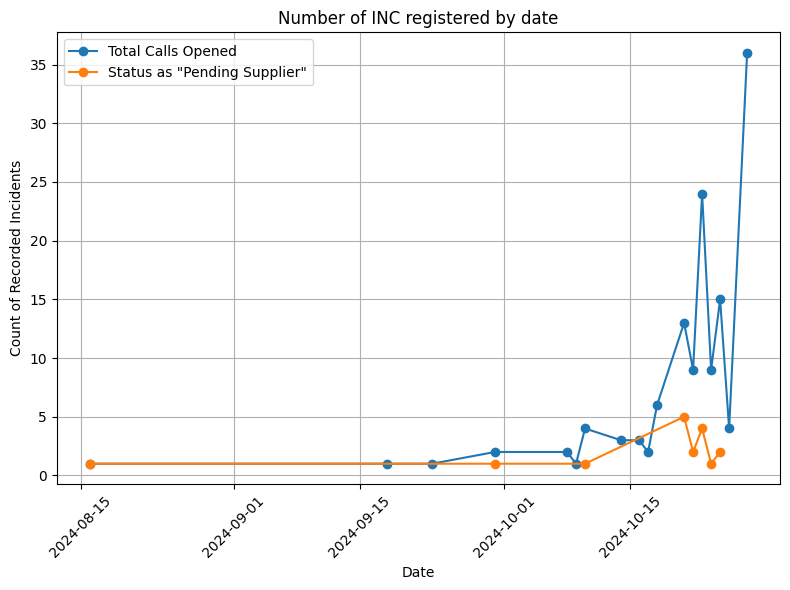

'\nAjustar esse grafico para mostrar a timeline somente dos chamados abertos dos chamados pendentes de fornecedor.\n'

In [23]:
# 5.0 - The field "Incident Status" as Pending Supplier and field Supplier as "Null" value.

pending_supplier_df = df[df['Incident_State'] == "Pending Supplier"]
opened_at_counts = df['Opened'].dt.date.value_counts().sort_index()
pending_supplier_counts = pending_supplier_df['Opened'].dt.date.value_counts().sort_index()

plt.figure(figsize=(8, 6))
plt.plot(opened_at_counts.index, opened_at_counts.values, label='Total Calls Opened', marker='o')
plt.plot(pending_supplier_counts.index, pending_supplier_counts.values, label='Status as "Pending Supplier"', marker='o')
plt.title('Number of INC registered by date')
plt.xlabel('Date')
plt.ylabel("Count of Recorded Incidents")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig('./output_data/html_element_5_0.png', dpi=150)
plt.show()

"""
Ajustar esse grafico para mostrar a timeline somente dos chamados abertos dos chamados pendentes de fornecedor.
"""


In [24]:
# 5.1 - Report listing the incidents in which the State is "Pending Supplier" and the Supplier is null

df_5_1 = df[(df['Incident_State'] == "Pending Supplier") & (df['Supplier'].isnull())]
df_5_1 = customising_order_of_columns(df_5_1, 'supplier_view')
df_5_1.head()


,Number,Service,Area,BU,Opened,Caller,Assignment_Group,Assigned,Incident_Type,Impact,Supplier
62,INC61412580,PRINTER SUPPORT DSC LATAM,BR,DSC,2024-10-24 10:29:30,Rodrigo Camargo Bueno,AMER-ITS-BR-LaserPrinter,Arthur da Fonseca Junior,Incident,User(s),NaN
84,INC61393837,PRINTER SUPPORT DSC LATAM,BR,DSC,2024-10-23 08:35:36,Vanderson Mario de Souza Machado,AMER-ITS-BR-LaserPrinter,Arthur da Fonseca Junior,Incident,User(s),NaN
85,INC61393685,PRINTER SUPPORT DSC LATAM,BR,DSC,2024-10-23 08:26:24,Vanderson Mario de Souza Machado,AMER-ITS-BR-LaserPrinter,Arthur da Fonseca Junior,Incident,User(s),NaN
96,INC61375842,PRINTER SUPPORT DSC LATAM,BR,DSC,2024-10-22 08:24:02,Natalia Leticia Pereira,AMER-ITS-BR-LaserPrinter,Arthur da Fonseca Junior,Incident,User(s),NaN
97,INC61364740,PRINTER SUPPORT DSC LATAM,BR,DSC,2024-10-21 17:23:51,Welison Da Silva Henrique,AMER-ITS-BR-LaserPrinter,Arthur da Fonseca Junior,Incident,User(s),NaN


In [25]:
# 5.2 - Report listing the incidents in which the State is "Pending Supplier" and the Supplier is not null

df_5_2 = df[(df['Incident_State'] == "Pending Supplier") & (df['Supplier'].notnull())]
df_5_2 = customising_order_of_columns(df_5_2, 'supplier_view')
df_5_2.head()


,Number,Service,Area,BU,Opened,Caller,Assignment_Group,Assigned,Incident_Type,Impact,Supplier
41,INC61431951,DESKTOP SUPPORT DSC LATAM,BR,DSC,2024-10-25 16:25:40,Andrea Silva,AMER-ITS-BR-FieldSupport,Davi Soares de Oliveira Junior,Incident,User(s),DELL BRAZIL
53,INC61427624,DESKTOP SUPPORT DSC LATAM,BR,DSC,2024-10-25 09:44:37,RONY CARLOS HIRATA,AMER-ITS-BR-FieldSupport,Juan Junior Andrade,Incident,User(s),DELL BRAZIL
81,INC61399570,DESKTOP SUPPORT DSC LATAM,BR,DSC,2024-10-23 15:03:45,Shirlei Saturnino Dos Santos,AMER-ITS-BR-FieldSupport,Davi Soares de Oliveira Junior,Incident,User(s),DELL BRAZIL
87,INC61386720,DESKTOP SUPPORT DSC LATAM,BR,DSC,2024-10-23 00:59:09,Piero Alonso Chinte Aguilar,AMER-ITS-BR-FieldSupport,Daniel Gracioso Justino,Incident,User(s),LENOVO BRAZIL
94,INC61377154,DESKTOP SUPPORT DSC LATAM,BR,DSC,2024-10-22 09:36:04,Maiume Aguiar Pereira,AMER-ITS-BR-FieldSupport,Ricardo Dias Almeida,Incident,User(s),LENOVO BRAZIL


### 6.0 - Descriptive Statistics Report 


In [26]:
# Verificar as primeiras linhas do DataFrame
print(f'Verificar as primeiras linhas do DataFrame: \n {df.head()}')


Verificar as primeiras linhas do DataFrame: 
         Number                              Caller  \
0  INC61458671              Bruno Vinicius Machado   
1  INC61458573  leonardo santana marcondes pereira   
2  INC61458545          Paloma Ester Ferreira Lima   
3  INC61458464                       Luciane Silva   
4  INC61458196                       Diego Morales   

                 Incident_Type   Impact  \
0                     Incident  User(s)   
1  Request for Standard Change  User(s)   
2  Request for Standard Change  User(s)   
3  Request for Standard Change  User(s)   
4                     Incident  User(s)   

                                   Short_Description Area       BU  \
0                           BR/DSC/Microsoft PowerBI   BR      DSC   
1  BR  DSC  - LDAP - Conta desabilitada devido ao...   BR      DSC   
2  BR - DSC - São Paulo - MFA - Necessidade de re...   BR      DSC   
3           BR - EXP - Ativação do Roaming - celular   BR  Express   
4                   

In [27]:
# Obter uma descrição estatística das colunas numéricas
print(f': Obter uma descrição estatística das colunas numéricas\n {df.describe()}')


: Obter uma descrição estatística das colunas numéricas
               SLA                         Opened  \
count  135.000000                            136   
mean    38.372667  2024-10-22 07:36:01.867646976   
min      0.000000            2024-08-16 09:35:27   
25%      1.175000  2024-10-21 14:28:09.750000128   
50%     12.990000     2024-10-23 16:00:51.500000   
75%     53.125000            2024-10-28 07:59:41   
max    396.370000            2024-10-28 17:15:32   
std     64.950940                            NaN   

                             Updated  cmdb_ci.asset_tag  u_complaint_reason  \
count                            136          14.000000                 0.0   
mean   2024-10-26 19:32:38.580882176       91499.071429                 NaN   
min              2024-10-21 12:56:21       24438.000000                 NaN   
25%    2024-10-25 15:09:55.750000128       50419.500000                 NaN   
50%       2024-10-28 08:20:18.500000       90892.500000                 NaN   


In [28]:
# Obter uma descrição estatística das colunas categóricas
print(f'Obter uma descrição estatística das colunas categóricas: \n {df.describe(include=['object'])}')


Obter uma descrição estatística das colunas categóricas: 
              Number          Caller                Incident_Type  \
count           136             136                          136   
unique          136             103                            4   
top     INC61458671  Ana Archangelo  Request for Standard Change   
freq              1              11                           89   

              Impact       Short_Description Area   BU  \
count            136                     136  136  136   
unique             2                      96    3    2   
top     None / Minor  BR/DSC - Reserva de IP   BR  DSC   
freq              84                      19  130  103   

                Assignment_Group assignment_group.manager.email  \
count                        136                            136   
unique                         6                              2   
top     AMER-ITS-BR-FieldSupport        douglas.provazi@dhl.com   
freq                          88         

In [29]:
# Verificar informações gerais sobre o DataFrame
print(f"Verificar informações gerais sobre o DataFrame: \n {df.info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 39 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Number                            136 non-null    object        
 1   Caller                            136 non-null    object        
 2   Incident_Type                     136 non-null    object        
 3   Impact                            136 non-null    object        
 4   Short_Description                 136 non-null    object        
 5   Area                              136 non-null    object        
 6   BU                                136 non-null    object        
 7   Assignment_Group                  136 non-null    object        
 8   assignment_group.manager.email    136 non-null    object        
 9   Assigned                          109 non-null    object        
 10  Assigned_Email                    109 non-null    

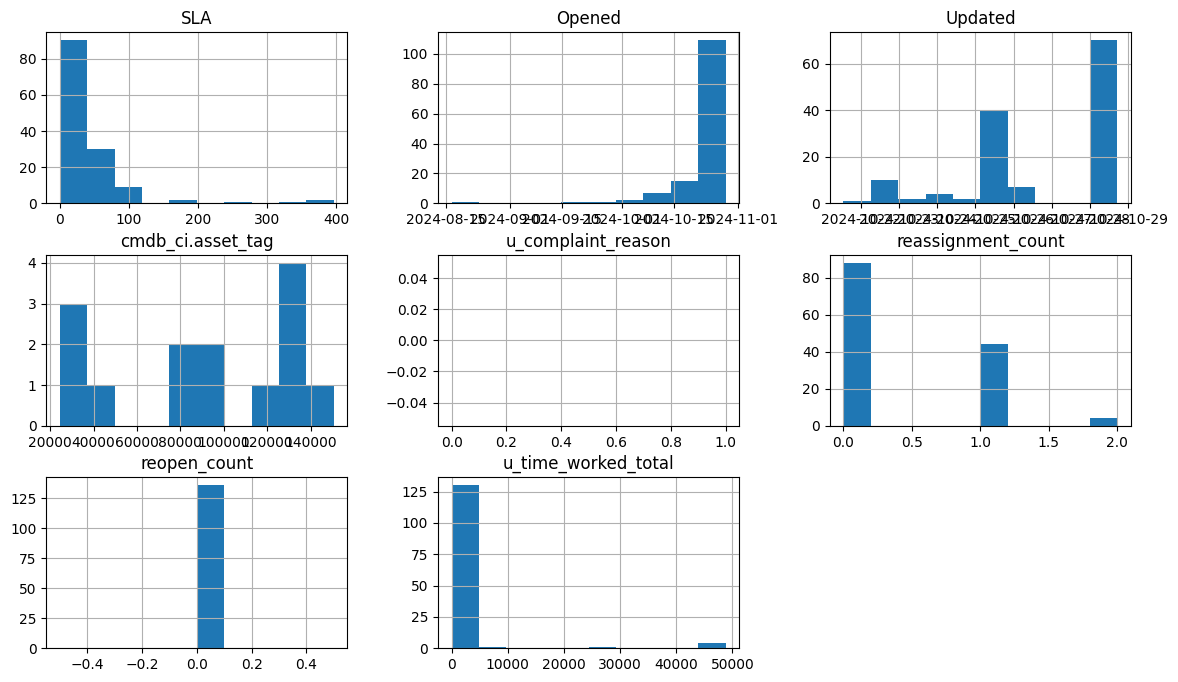

In [30]:
# Histograma das colunas numéricas:
df.hist(figsize=(14, 8))
plt.show()



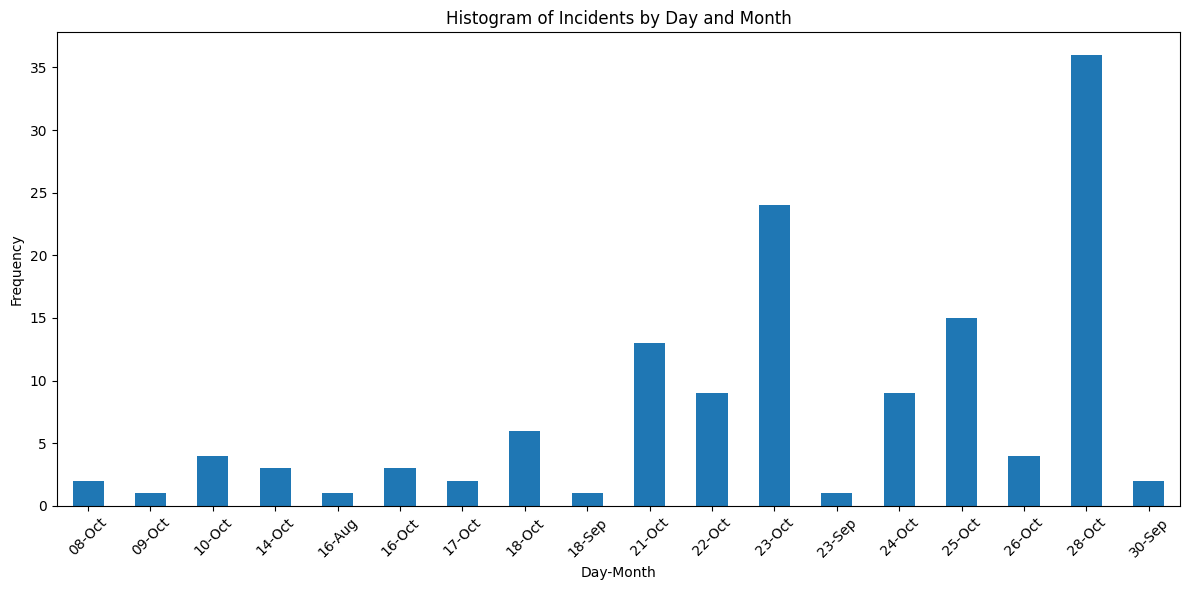

In [31]:
#Histograma das colunas numéricas:
#df.hist(figsize=(8, 6))
#plt.show()

# Convert the 'Opened' column to datetime if it's not already
df['Opened'] = pd.to_datetime(df['Opened'])

# Extract day and month for plotting
df['Day_Month'] = df['Opened'].dt.strftime('%d-%b')

# Plot histogram
df['Day_Month'].value_counts().sort_index().plot(kind='bar', figsize=(12, 6))
plt.xlabel('Day-Month')
plt.ylabel('Frequency')
plt.title('Histogram of Incidents by Day and Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


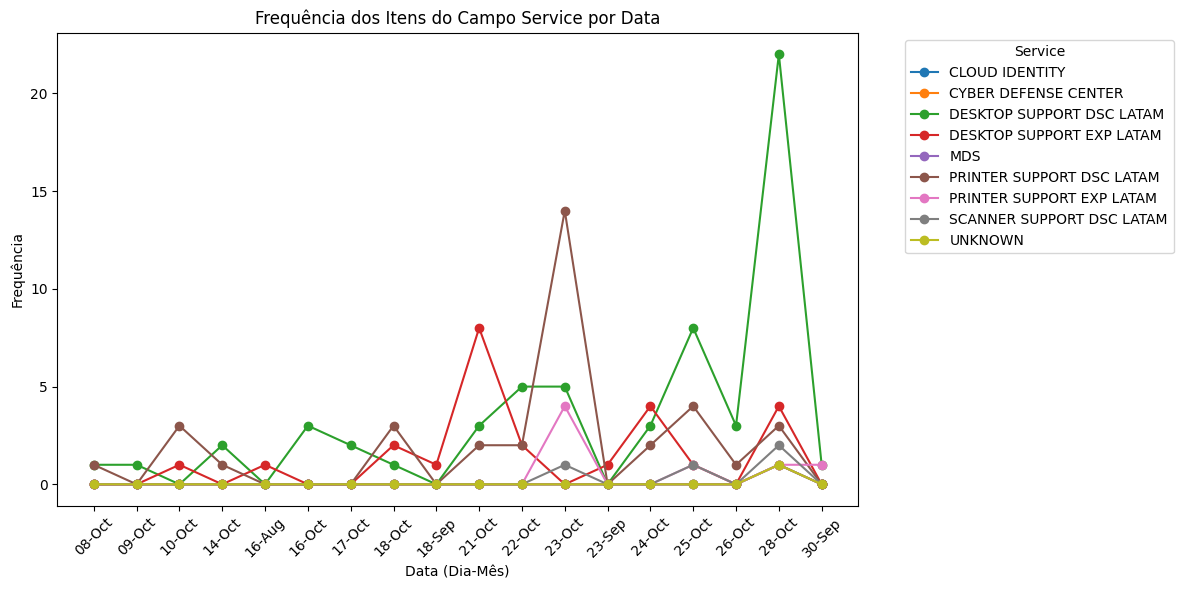

In [32]:
# Agrupar os dados por 'Opened' e 'Service' e contar a frequência
service_date_counts = df.groupby([df['Opened'].dt.strftime('%d-%b'), 'Service']).size().unstack(fill_value=0)

# Plotar o gráfico de linhas
plt.figure(figsize=(12, 6))
for service in service_date_counts.columns:
    plt.plot(service_date_counts.index, service_date_counts[service], marker='o', label=service)

plt.title('Frequência dos Itens do Campo Service por Data')
plt.xlabel('Data (Dia-Mês)')
plt.ylabel('Frequência')
plt.legend(title='Service', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

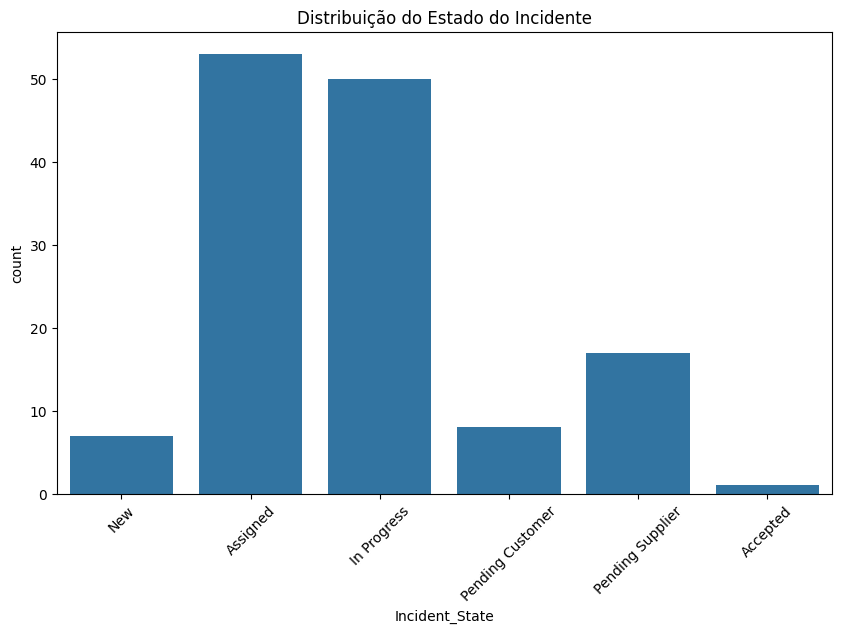

In [33]:
# Exemplo para a coluna 'Incident_State'
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Incident_State')
plt.xticks(rotation=45)
plt.title('Distribuição do Estado do Incidente')
plt.show()

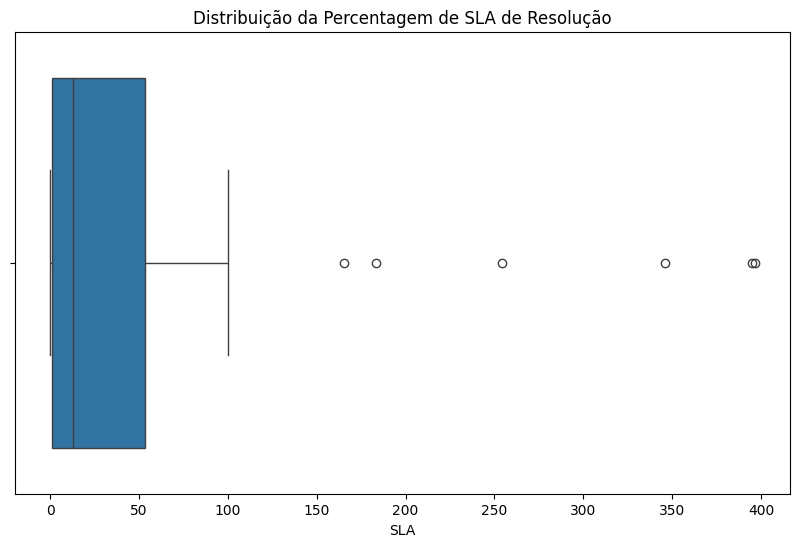

In [34]:
# Boxplot para analisar a distribuição de uma métrica numérica:

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='SLA')
plt.title('Distribuição da Percentagem de SLA de Resolução')
plt.show()


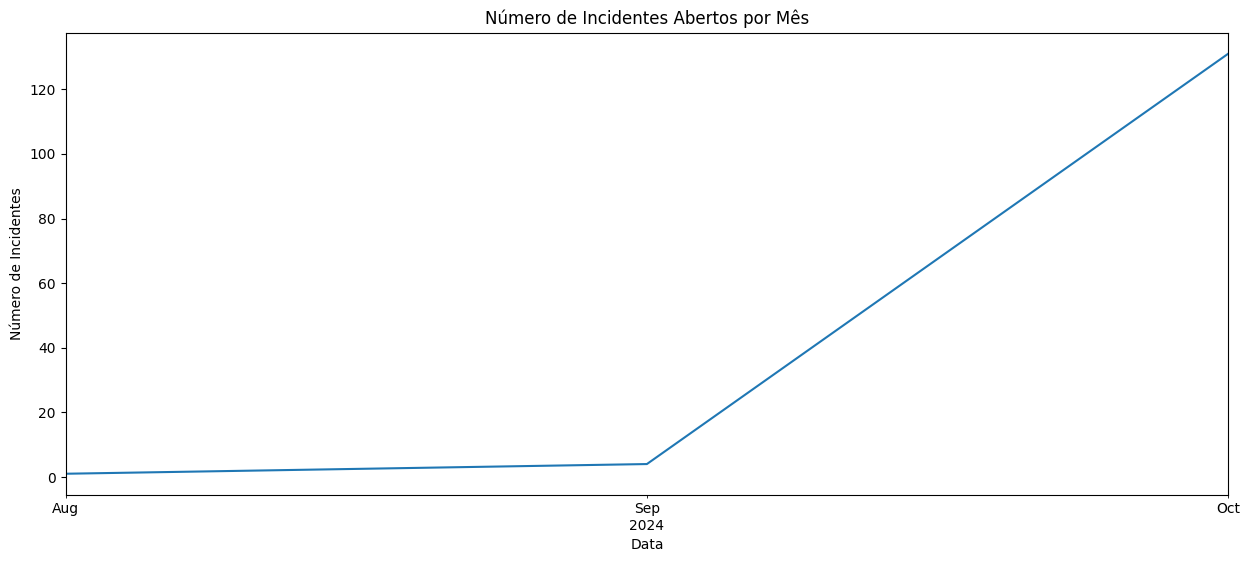

In [35]:
# Contagem de incidentes ao longo do tempo
df['Opened'].groupby(df['Opened'].dt.to_period('M')).count().plot(kind='line', figsize=(15, 6))
plt.title('Número de Incidentes Abertos por Mês')
plt.xlabel('Data')
plt.ylabel('Número de Incidentes')
plt.show()

In [36]:
# Tabela resumida para colunas numéricas
summary_num = df.describe().transpose()
print(summary_num)

                     count                           mean  \
SLA                  135.0                      38.372667   
Opened                 136  2024-10-22 07:36:01.867646976   
Updated                136  2024-10-26 19:32:38.580882176   
cmdb_ci.asset_tag     14.0                   91499.071429   
u_complaint_reason     0.0                            NaN   
reassignment_count   136.0                       0.382353   
reopen_count         136.0                            0.0   
u_time_worked_total  136.0                    2494.852941   

                                     min                            25%  \
SLA                                  0.0                          1.175   
Opened               2024-08-16 09:35:27  2024-10-21 14:28:09.750000128   
Updated              2024-10-21 12:56:21  2024-10-25 15:09:55.750000128   
cmdb_ci.asset_tag                24438.0                        50419.5   
u_complaint_reason                   NaN                            NaN   


In [37]:
# Tabela resumida para colunas categóricas
summary_cat = df.describe(include=['object']).transpose()
print(summary_cat)



                                 count unique  \
Number                             136    136   
Caller                             136    103   
Incident_Type                      136      4   
Impact                             136      2   
Short_Description                  136     96   
Area                               136      3   
BU                                 136      2   
Assignment_Group                   136      6   
assignment_group.manager.email     136      2   
Assigned                           109     17   
Assigned_Email                     109     17   
Site                               102     50   
Level                              136      3   
Incident_State                     136      6   
Service                            136      9   
u_service.u_accountmanager.email   132      1   
u_service.owned_by.email           136      6   
Accepted                            78     78   
TRT                                135    130   
Supplier            

In [38]:
# Tabela resumida para colunas categóricas
#summary_cat = df.describe(include=['object']).transpose()
#summary_cat.to_html('./output_data/summary_cat.html')



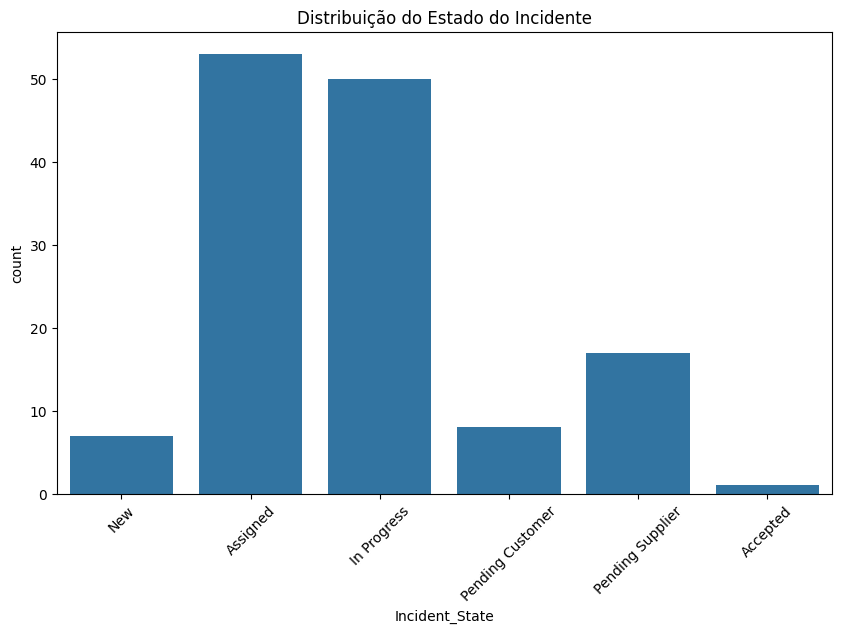

In [39]:
# Salvar um gráfico
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Incident_State')
plt.xticks(rotation=45)
plt.title('Distribuição do Estado do Incidente')
#plt.savefig('incident_state_distribution.png')
plt.show()

# Salvar uma tabela como CSV
#summary_num.to_csv('summary_numeric.csv')
#summary_cat.to_csv('summary_categorical.csv')